# Objective: Does higher GDP and income per capita necessarily dictate higher waste?

## Setup

In [13]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

## Read data

In [2]:
path_to_dataset = r'C:\\Users\\patil\\Documents\\GitHub\\trashmap\\data\\processed'
filename = '01a_country_level_data.csv'
full_file_path = os.path.join(path_to_dataset, filename)
df = pd.read_csv(full_file_path)

In [3]:
df

,country,income,gdp,population,total_msw,msw_per_cap
0,Aruba,HIC,35563.312500,103187.0,8.813202e+04,774.826708
1,Afghanistan,LIC,2057.062256,34656032.0,5.628525e+06,147.336942
2,Angola,LMC,8036.690430,25096150.0,4.213644e+06,152.316361
3,Albania,UMC,13724.058590,2854191.0,1.087447e+06,345.637478
4,Andorra,HIC,43711.800780,82431.0,4.300000e+04,473.231612
...,...,...,...,...,...,...
209,Kosovo,LMC,9723.561523,1801800.0,3.190000e+05,160.612729
210,"Yemen, Rep.",LIC,8269.671875,27584212.0,4.836820e+06,159.072536
211,South Africa,UMC,12666.607420,51729344.0,1.845723e+07,323.687152
212,Zambia,LMC,3201.289307,14264756.0,2.608268e+06,165.876066


## Check for assumptions of ANOVA:
Independent var (income levels) is categorical, dependent (MSW per capita) is metric and continuous
Measurements are independent
Are the samples normally distributed and have roughly equal variance?

In [5]:
filename = '02a_msw_per_cap_by_income_kdeplot.jpeg'
full_file_path = os.path.join(path_to_dataset, filename)

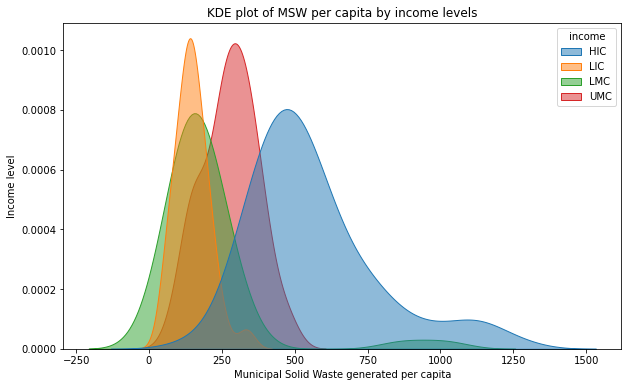

In [6]:
plt.figure(figsize=(10,6))
sns.kdeplot(data = df, x = 'msw_per_cap', hue = 'income', fill = True, alpha = 0.5)
plt.title(f'KDE plot of MSW per capita by income levels')
plt.xlabel('Municipal Solid Waste generated per capita')
plt.ylabel('Income level')
plt.savefig(full_file_path)

On the outset, data looks normally distributed but definitely not euqal variance. Checking with statistical test

### Test for normality

In [15]:
inc_level = list(df['income'].unique())
alpha = 0.5

In [19]:
for inc in inc_level:
    group = df[df['income'] == inc]['msw_per_cap']
    shapiro_statistic, p_value = stats.shapiro(group)
    if p_value < alpha:
        print(f"p-value {round(p_value,2)} Reject hypothesis: Non-normal distribution for income level {inc}")
    else:
        print (f"p-value {round(p_value,2)} Fail to reject hypothesis: Normal distribution for income level {inc}")

p-value 0.0 Reject hypothesis: Non-normal distribution for income level HIC
p-value 0.1 Reject hypothesis: Non-normal distribution for income level LIC
p-value 0.0 Reject hypothesis: Non-normal distribution for income level LMC
p-value 0.57 Fail to reject hypothesis: Normal distribution for income level UMC


### Test for equal variance

In [ ]:
df.groupby('income')['ms']

In [21]:
groups = [df[df['income'] == inc]['msw_per_cap'].values for inc in inc_level]
levene_statistic, p_value = stats.levene(*groups, center='median')
if p_value < alpha:
    print(f"p-value {round(p_value,2)} Reject hypothesis: Unequal variances")
else:
    print (f"p-value {round(p_value,2)} Fail to reject hypothesis: Equal variances")

p-value 0.0 Reject hypothesis: Unequal variances
